# Example 1: A simple p-n junction

First, we import deltapv and necessary libraries. Notably, we use `jax`'s version of `numpy`, which is purely functional and presents immutable arrays.

In [1]:
import deltapv as dpv
from jax import numpy as jnp, value_and_grad, jacobian
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
___________________    __
______ \ __  __ \_ |  / /
_  __  /__  /_/ /_ | / / 
/ /_/ / _  ____/__ |/ /  
\__,_/  /_/     _____/   
                         


`deltapv` has a streamlined interface which allows defining a cell design with several lines of code. First, we must define the material that makes up the cell, which for the purpose of the example is a homojunction. The parameters have default values, so recombination parameters are not supplied here. Moreover, the units required are as follows:

`eps` : unitless

`Chi` , `Eg` , `Et` : eV

`Nc` , `Nv` , `Ndop` : cm^(-3)

`mn` , `mp` : cm^2 / V / s

`tn` , `tp` : s

`A` : cm^(-1) eV^(-1/2)

In [2]:
material = dpv.create_material(Chi=3.9,
                                Eg=1.5,
                                eps=9.4,
                                Nc=8e17,
                                Nv=1.8e19,
                                mn=100,
                                mp=100,
                                Et=0,
                                tn=1e-8,
                                tp=1e-8,
                                A=2e4)

We are ready to define the cell. The recombination velocities, in the format `(Snl, Snr, Spl, Spr)`, are in units cm/s. We have equal donor and acceptor densities on either side of the pn junction, which has two layers of equal thickness 1e-4 cm. We simply use a uniform grid of 500 points for this example; where custom grids are required, the argument `grid` can be used to pass one.

In [3]:
des = dpv.make_design(n_points=500, Ls=[1e-4, 1e-4], mats=material, Ns=[1e17, -1e17], Snl=1e7, Snr=0, Spl=0, Spr=1e7)

While a `PVDesign` object contains all information about the cell, it does not contain light source information. In order to specify a custom light source, we must create a LightSource object with the `incident_light` function. This defaults to returning the spectrum of one sun, but the spectrum can be specified with the `kind` (`"sun"`, `"white"`, `"monochromatic"`, or `"user"`) and the wavelengths, `Lambda`, and corresponding power, `P_in`, respectively. However, the simulator defaults to using the solar spectrum when no light source object is passed, so it is unnecessary here.

Now we are ready to run the simulation, which solves for the equilibrium system, then the out-of-equilibrium case with illumination and bias up to the point when the current drops below zero.

In [4]:
results = dpv.simulate(des)

Solving equilibrium...
    iteration   1    |p| = 4.35e+01    |F| = 8.29e+00
    iteration   2    |p| = 3.77e+01    |F| = 5.70e+00
    iteration   3    |p| = 2.92e+01    |F| = 4.51e+00
    iteration   4    |p| = 1.95e+01    |F| = 3.71e+00
    iteration   5    |p| = 1.28e+01    |F| = 2.93e+00
    iteration   6    |p| = 1.34e+01    |F| = 2.20e+00
    iteration   7    |p| = 1.16e+01    |F| = 1.55e+00
    iteration   8    |p| = 8.94e+00    |F| = 1.06e+00
    iteration   9    |p| = 6.17e+00    |F| = 7.65e-01
    iteration  10    |p| = 3.72e+00    |F| = 4.73e-01
    iteration  11    |p| = 1.72e+00    |F| = 2.29e-01
    iteration  12    |p| = 3.43e-01    |F| = 5.58e-02
    iteration  13    |p| = 6.32e-12    |F| = 4.65e-14
Solving for 0.00 V (Step   0)...
    iteration   1    |p| = 1.00e+00    |F| = 4.65e+01
    iteration   2    |p| = 1.00e+00    |F| = 1.71e+01
    iteration   3    |p| = 1.02e+00    |F| = 2.59e+00
    iteration   4    |p| = 1.63e+00    |F| = 2.76e-01
    iteration   5    |p| =

The results returned are in the form of a dictionary with keys `{"cell", "eq", "pots", "mpp", "eff", "iv", "vmax"}`. `"cell"` refers to the initialized PVCell object which contains the generation density G from the optical model. `"eq"` and `"pots"` are the solution potentials in the form of a named tuple for the equilibrium and out of equilibrium cases. `"mpp"` is the maximal power through the cell, `"iv"` is a tuple of  voltages and currents describing the IV curve, and `"vmax"` is the interpolated maximal power point. deltapv provides several plotting functions, all of which can save the plot with keyword argument `"filename"`.

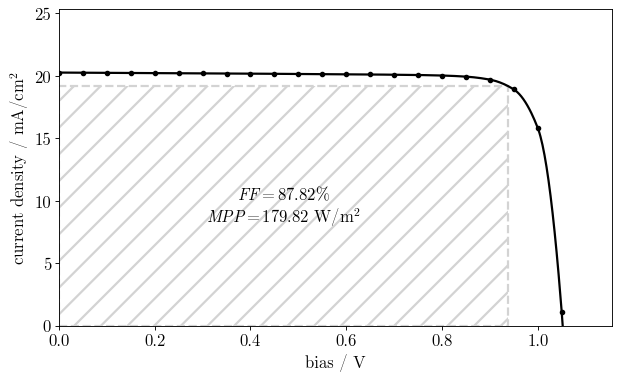

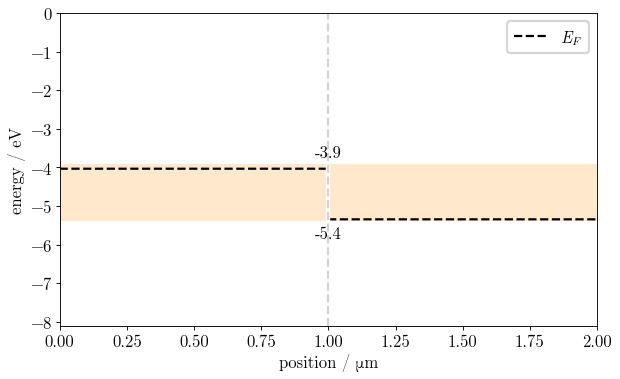

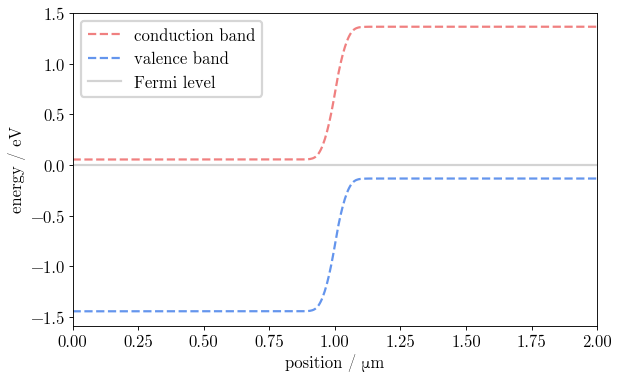

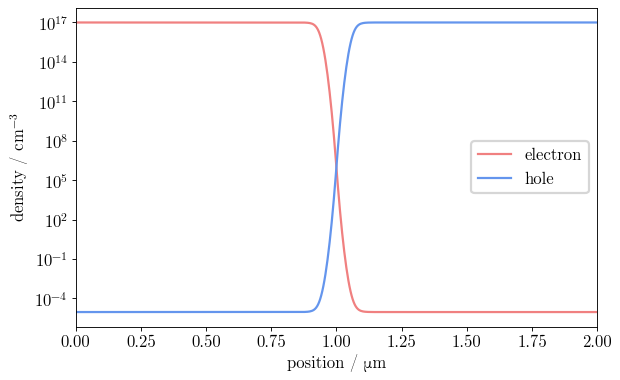

In [5]:
dpv.plot_iv_curve(*results["iv"])
dpv.plot_bars(des)
dpv.plot_band_diagram(des, results["eq"], eq=True)
dpv.plot_charge(des, results["eq"])

# Example 2: Optimizing a perovskite solar cell

First we define the fixed parameters below, together with the lower and upper bounds for all the optimized variables. The perovskite material is held fixed in this example, so we define it beforehand.

In [6]:
L_ETM = 5e-5
L_Perov = 1.1e-4
L_HTM = 5e-5
N = 500
A = 2e4
tau = 1e-6
S = 1e7
Eg_P = 1.5
Chi_P = 3.9
eps_P = 10
Nc_P = 3.9e18
Nv_P = 2.7e18
mn_P = 2
mp_P = 2
Br_P = 2.3e-9

Perov = dpv.create_material(Eg=Eg_P, Chi=Chi_P, eps=eps_P,
                            Nc=Nc_P, Nv=Nv_P, mn=mn_P,
                            mp=mp_P, tn=tau, tp=tau,
                            Br=Br_P, A=A)

vl = jnp.array([1, 1, 1, 17, 17, 0, 0, 1, 1, 1, 17, 17, 0, 0, 17, 17], dtype=jnp.float64)
vu = jnp.array([5, 5, 20, 20, 20, 3, 3, 5, 5, 20, 20, 20, 3, 3, 20, 20], dtype=jnp.float64)

Aside from the box constraints, we also enforce 5 generally nonlinear constraints for band alignment. We define it below. We will also need the jacobian of the constraint, which can be easily obtained by `jax`'s `jacobian` function. Additionally, we need `numpy`-compatible wrappers for `g` and its derivative for the sake using `scipy` optimization algorithms.

In [7]:
def g(x):
    Eg_ETM = x[0]
    Chi_ETM = x[1]
    Nc_ETM = 10**x[3]
    Nv_ETM = 10**x[4]
    Eg_HTM = x[7]
    Chi_HTM = x[8]
    Nc_HTM = 10**x[10]
    Nv_HTM = 10**x[11]
    Nd_ETM = 10**x[14]
    Na_HTM = 10**x[15]

    PhiM0 = dpv.physics.flatband_wf(Nc_ETM, Nv_ETM, Eg_ETM, Chi_ETM, Nd_ETM)
    PhiML = dpv.physics.flatband_wf(Nc_HTM, Nv_HTM, Eg_HTM, Chi_HTM, -Na_HTM)

    g = -jnp.array([
        Chi_ETM - PhiM0, Chi_HTM - Chi_P, PhiML - Chi_HTM - Eg_HTM,
        Chi_HTM + Eg_HTM - Chi_P - Eg_P, Chi_P - Chi_ETM
    ])

    return g

dg = jacobian(g)
g_np = lambda x: np.array(g(jnp.array(x)))
dg_np = lambda x: np.array(dg(jnp.array(x)))

Finally, we specify how to convert a parameter vector into a `PVDesign`, and the objective function `f` makes use of this to return the penalized negative efficiency given a parameter vector.

JAX's `value_and_grad` function is then used to differentiate `f` in an end-to-end manner, returning a function, `df`, which returns both the efficiency and its gradient with respect to the parameter vector. Again, we will need `numpy` wrappers.

In [8]:
def x2des(params, perov=Perov):
    Eg_ETM = params[0]
    Chi_ETM = params[1]
    eps_ETM = params[2]
    Nc_ETM = 10**params[3]
    Nv_ETM = 10**params[4]
    mn_ETM = 10**params[5]
    mp_ETM = 10**params[6]
    Eg_HTM = params[7]
    Chi_HTM = params[8]
    eps_HTM = params[9]
    Nc_HTM = 10**params[10]
    Nv_HTM = 10**params[11]
    mn_HTM = 10**params[12]
    mp_HTM = 10**params[13]
    Nd_ETM = 10**params[14]
    Na_HTM = 10**params[15]

    ETM = dpv.create_material(Eg=Eg_ETM,
                            Chi=Chi_ETM,
                            eps=eps_ETM,
                            Nc=Nc_ETM,
                            Nv=Nv_ETM,
                            mn=mn_ETM,
                            mp=mp_ETM,
                            tn=tau,
                            tp=tau,
                            A=A)
    HTM = dpv.create_material(Eg=Eg_HTM,
                            Chi=Chi_HTM,
                            eps=eps_HTM,
                            Nc=Nc_HTM,
                            Nv=Nv_HTM,
                            mn=mn_HTM,
                            mp=mp_HTM,
                            tn=tau,
                            tp=tau,
                            A=A)

    des = dpv.make_design(n_points=N, Ls=[L_ETM, L_Perov, L_HTM], mats=[ETM, perov, HTM], Ns=[Nd_ETM, 0, -Na_HTM], Snl=S, Snr=S, Spl=S, Spr=S)

    return des


def f(params):
    des = x2des(params)
    results = dpv.simulate(des, verbose=False)
    eff = results["eff"] * 100
    return -eff

df = value_and_grad(f)

def f_np(x):
    y, dy = df(x)
    result = float(y), np.array(dy)
    print("objective:", -result[0])
    return result

We are now ready to begin the optimization process! We will use the Sequential Least Squares Programming (SLSQP) algorithm from `scipy`.

In [10]:
x0 = np.array([1.661788237392516, 4.698293002285373, 19.6342803183675, 18.83471869026531, 19.54569869328745, 0.7252792557586427, 1.6231392299175988, 2.5268524699070234, 2.51936429069554, 6.933634938056497, 19.41835918276137, 18.271793488422656, 0.46319949214386513, 0.2058139980642224, 18.63975340175838, 17.643726318153238])

slsqp_res = minimize(f_np,
                     x0=x0,
                     method="SLSQP",
                     jac=True,
                     bounds=list(zip(vl, vu)),
                     constraints=[{
                         "type": "ineq",
                         "fun": g_np,
                         "jac": dg_np
                     }],
                     options={
                         "maxiter": 50,
                         "disp": True
                     })

objective: 6.485463574968025
objective: 18.178760280077256
objective: 18.82135123858642
objective: 18.84295448016842
objective: 20.830058096069024
objective: 18.855918659563343
objective: 19.324090095163957
objective: 20.044657777085042
objective: 20.83863338897177
objective: 21.132664873345163
objective: 20.614592607250923
objective: 21.366072197115233
objective: 21.604711635218628
objective: 21.6584191894066
objective: 21.669883319115453
objective: 21.67333526911542
objective: 21.681692730660984
objective: 21.68369054586656
objective: 21.67876166491312
objective: 21.684194431619748
objective: 21.684358226867094
Optimization terminated successfully    (Exit mode 0)
            Current function value: -21.684358226867094
            Iterations: 15
            Function evaluations: 21
            Gradient evaluations: 15


The algorithm converges in less than couple dozen of function calls, which takes no more than a few minutes. We can inspect the initial and optimized designs by plotting the isolated energy levels:

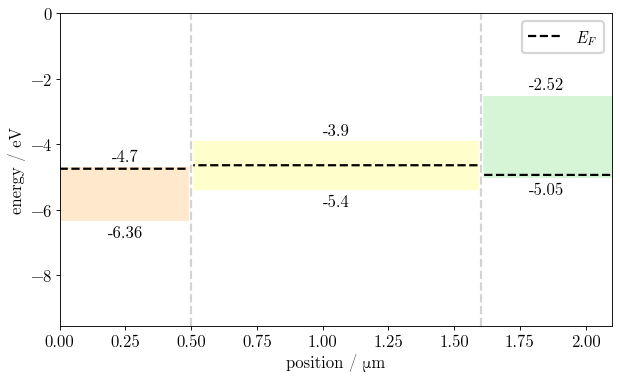

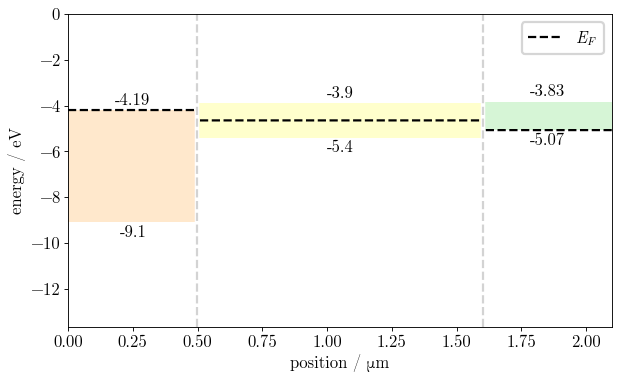

In [11]:
dpv.plot_bars(x2des(x0))
dpv.plot_bars(x2des(slsqp_res["x"]))

# Example 2: Using empirical $IV$ curve for material discovery

Here, we extend the use of gradients to "discover" unknown parameters using an experimentally acquired $IV$ curve. Now suppose we have a material whose $E_g$ and $\mu_p$ are unknown, and we have a "target" $IV$ curve from empirical measurements, $J^*$ (which will be generated via simulation here for the sake of the example). We use simulations to match the candidate and empirical $IV$ curves, specifically to minimize the radial difference between the two curves integrated in polar coordinates. This objective is conveniently provided by `deltapv`.

First, we create the material that we will investigate:

In [4]:
material = dpv.create_material(Eg=1.0,
                               Chi=3.0,
                               eps=10.0,
                               Nc=1e18,
                               Nv=1e18,
                               mn=130.0,
                               mp=160.0,
                               A=2e4)

Now we define a helper function that returns the $IV$ curve for a homojunction made of the material, but with guesses for $E_g$ and $\mu_p$ specified by the arguments. We also compute the "empirical" $IV$ curve, which we will use to define the objective function.

In [5]:
def get_iv(Eg, mp):
    candidate = dpv.objects.update(material, Eg=Eg, mp=mp)
    des = dpv.make_design(n_points=500,
                          Ls=[1e-4, 1e-4],
                          mats=candidate,
                          Ns=[1e17, -1e17],
                          Snl=1e7,
                          Snr=0,
                          Spl=0,
                          Spr=1e7)
    results = dpv.simulate(des, verbose=False)
    return results["iv"][1]

J0 = get_iv(Eg=1.0, mp=160.0)

Now we define the objective function. Since $\mu_p$ has values in a large range, we transform the optimization variable to the log of it. The function simply computes the $IV$ curve with the proposed parameters, and uses the polar residual function provided by deltapv to compute the objective. With the help of `jax`, we can immediately get the gradient of the function as well. Once again, we need a `numpy` wrapper. We will append the candidate point and objective to a list from inside the objective function to keep track of the optimization process.

In [6]:
def r(x):
    mp = 10**x[0]
    Eg = x[1]
    J = get_iv(Eg=Eg, mp=mp)
    res = dpv.util.dpol(J, J0)
    return res

dr = value_and_grad(r)

xs = []
ys = []

def r_np(x):
    y, dy = dr(x)
    result = float(y), np.array(dy)
    xs.append(x)
    ys.append(float(y))
    print("objective:", result[0])
    return result

What remains is to perform the optimization using SLSQP! This will be quick:

In [7]:
result = minimize(r_np,
                x0=np.array([2.0, 1.2]),
                method="SLSQP",
                jac=True,
                bounds=[(1.0, 3.0), (0.5, 2.0)],
                options={
                    "maxiter": 50,
                    "disp": True
                })

objective: 1.415470916657147
objective: 18.01595761330103
objective: 0.11232361785449733
objective: 0.10107472364524467
objective: 0.009396799546705414
objective: 0.0005790198496131636
objective: 9.78384312195237e-05
objective: 3.3898534113117285e-06
objective: 1.3971387383125255e-08
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3971387383125255e-08
            Iterations: 7
            Function evaluations: 9
            Gradient evaluations: 7


Examining the objective, we see it going down rapidly. The optimized parameters are also clearly very close to the true values, which were $E_g = 1, \mu_p = 160$:

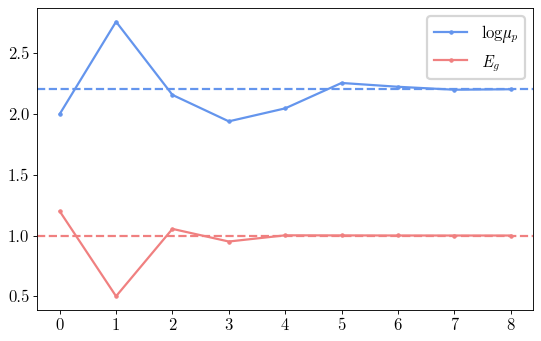

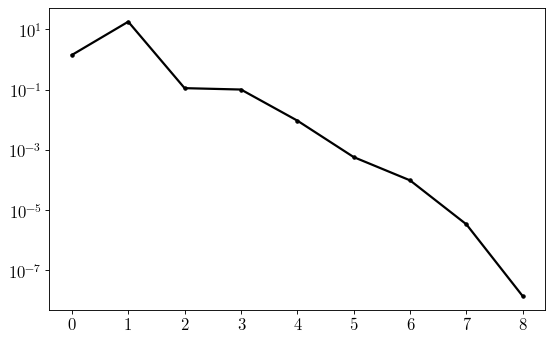

In [10]:
xs = np.array(xs)

plt.plot(xs[:, 0], color="cornflowerblue", marker=".", label="$\log \mu_p$")
plt.axhline(np.log10(160), color="cornflowerblue", linestyle="--")
plt.plot(xs[:, 1], color="lightcoral", marker=".", label="$E_g$")
plt.axhline(1.0, color="lightcoral", linestyle="--")
plt.legend()
plt.show()

plt.plot(ys, color="black", marker=".")
plt.yscale("log")
plt.show()